![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Captioning with an Encoder-Decoder RNN

This notebook demonstrates how to build an image captioning model using a classic encoder-decoder architecture. This is a fascinating multi-modal task that combines Computer Vision (to understand the image) and Natural Language Processing (to generate a descriptive sentence).

### **📌 The Core Idea: Encoder-Decoder**
The model consists of two main parts that work together:

1.  **The Encoder**: A pre-trained Convolutional Neural Network (CNN), like ResNet, acts as the encoder. It takes an image as input and outputs a compact feature vector (an embedding). This vector is a rich, numerical representation of the image's content—its "thought" vector.

2.  **The Decoder**: A Recurrent Neural Network (RNN), specifically an LSTM in our case, acts as the decoder. It takes the image's feature vector from the encoder and generates the caption one word at a time. It learns the statistical structure of language to produce coherent sentences.

In [1]:
from IPython.display import display

In [2]:
# %pip install torch torchvision pillow spacy numpy
# %pip install torchtext
# %pip install pycocotools

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import random
from tqdm import tqdm
import kagglehub
import pandas as pd
from PIL import Image
import spacy
from IPython.display import display
import pickle
import os
import matplotlib.pyplot as plt

## 1️⃣ The Dataset: Flickr8k
We will use the Flickr8k dataset, a popular benchmark for image captioning. It contains:
- **8,000 Images**: Sourced from the Flickr website.
- **40,000 Captions**: Each image is paired with five different human-generated captions, providing a rich variety of descriptions.

First, we'll download the dataset from Kaggle Hub and inspect its contents.

In [4]:
# Download the Flickr8k dataset
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

Path to dataset files: /home/ali/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [5]:
# Load the captions from the `captions.txt` file
captions_path = os.path.join(path, "captions.txt")
captions_df = pd.read_csv(captions_path)
print(f"Captions loaded: {len(captions_df)} entries")
print(captions_df.head())

Captions loaded: 40455 entries
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [6]:
# Images directory
images_dir = os.path.join(path, "Images")
print(f"Images directory: {images_dir}")
print(f"Number of images: {len(os.listdir(images_dir))}")

Images directory: /home/ali/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images
Number of images: 8091


Sample caption: A child in a pink dress is climbing up a set of stairs in an entry way .


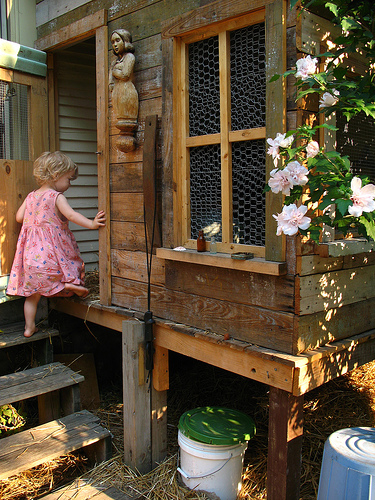

In [7]:
# Let's look at a sample image and one of its captions
print("Sample caption:", captions_df.iloc[0]['caption'])
sample_image_path = os.path.join(images_dir, captions_df.iloc[0]['image'])
sample_img = Image.open(sample_image_path)
display(sample_img)

## 2️⃣ Building the Vocabulary

Neural networks work with numbers, not words. Therefore, we need to build a **vocabulary** to map every unique word in our dataset to a unique integer index. We also add special tokens that are crucial for the training process:

- `<PAD>`: A padding token used to make all sequences in a batch the same length.
- `<SOS>`: A "Start of Sentence" token that signals the beginning of a caption to the decoder.
- `<EOS>`: An "End of Sentence" token that the model learns to predict when it has finished generating a caption.
- `<UNK>`: An "Unknown" token for words that appear in the test set but not in our training vocabulary.

We use the `spaCy` library for robust and efficient tokenization.

In [8]:
spacy_eng = spacy.load("en_core_web_sm") # you might need to run this: python -m spacy download en_core_web_sm

In [9]:
def word_tokenize(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

In [10]:
# Initialize vocabulary with special tokens
word_to_index = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
index_to_word = {idx: word for word, idx in word_to_index.items()}
word_freq = {}

# Build vocabulary from all captions in the dataset
for caption in tqdm(captions_df['caption']):
    tokens = word_tokenize(caption.lower())
    
    for token in tokens:
        if token not in word_to_index:
            idx = len(word_to_index)
            word_to_index[token] = idx
            index_to_word[idx] = token
            word_freq[token] = 1
        else:
            word_freq[token] += 1

print(f"\nVocabulary size: {len(word_to_index)}")

100%|██████████████████████████████████████████████████████████████████████████| 40455/40455 [00:00<00:00, 82379.49it/s]


Vocabulary size: 8508


In [11]:
word_tokenize('<SOS> hi, my friend <EOS>')  # We will manually add tokens for <EOS> and <SOS> etc after tokenization to avoid them breaking up.

['<', 'sos', '>', 'hi', ',', 'my', 'friend', '<', 'eos', '>']

## 3️⃣ The Model: A CNN-RNN Encoder-Decoder
Our model is composed of two main modules: an Encoder to process the image and a Decoder to generate the text.

### 🔹 The Encoder (CNN)
We use a pre-trained ResNet-50 model, which has already learned rich feature representations from the large ImageNet dataset. We perform two key modifications:
1.  **Freeze Layers**: We freeze all the convolutional layers (`requires_grad_(False)`) to prevent them from being updated during training. This is a form of transfer learning that speeds up training and prevents overfitting.
2.  **Replace Classifier**: We chop off the final, fully-connected classification layer (which originally predicts 1000 ImageNet classes) and replace it with a new `nn.Linear` layer. This new layer will output a feature vector of `embed_size`, which will be the input to our decoder.

### 🔹 The Decoder (RNN)
The decoder is an LSTM (Long Short-Term Memory) network, a type of RNN well-suited for sequence generation.

1.  **Embedding Layer**: It first converts the integer-coded words of the caption into dense vectors of size `embed_size`.
2.  **Input Concatenation**: The decoder's first input is the image feature vector from the encoder. For subsequent steps, it takes the embedded representation of the previously generated word.
3.  **LSTM**: The LSTM processes the sequence of inputs, maintaining a hidden state that keeps track of the context of the generated sentence.
4.  **Linear Layer**: A final linear layer maps the LSTM's output to the size of our vocabulary, producing a probability distribution over all possible next words.

### 🔹 The Inference Method (`caption_image`)
This method is used for generating new captions after the model is trained. It works *autoregressively*:
1.  The image is passed through the encoder to get its feature vector.
2.  This feature vector is fed into the decoder to predict the first word (which should be `<SOS>`).
3.  The predicted word is then fed back into the decoder as input for the next time step.
4.  This process repeats until the model predicts the `<EOS>` token or a maximum length is reached.

In [12]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        # Use a pretrained ResNet-50 and freeze its parameters
        self.resnet = models.resnet50(weights='IMAGENET1K_V1').requires_grad_(False)
        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # Key fix: Initialize hidden states from image features
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)
        
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, 1024),
            nn.Linear(1024, vocab_size)
        )
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        # Initialize hidden states with image features
        batch_size = features.size(0)
        h_0 = self.init_h(features).unsqueeze(0).repeat(self.rnn.num_layers, 1, 1)
        c_0 = self.init_c(features).unsqueeze(0).repeat(self.rnn.num_layers, 1, 1)
        
        embeddings = self.dropout(self.embed(captions))
        hiddens, _ = self.rnn(embeddings, (h_0, c_0))
        outputs = self.linear(hiddens)
        return outputs
    
class ImageCaptioner(nn.Module):
    """A wrapper model combining the Encoder and Decoder."""
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptioner, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, max_length=50):
        """Generate caption with proper image feature initialization."""
        result_caption = []

        with torch.no_grad():
            # Get image features
            features = self.encoder(image)
            
            # Initialize hidden states with image features
            batch_size = image.size(0)
            h_0 = self.decoder.init_h(features).unsqueeze(0).repeat(self.decoder.rnn.num_layers, 1, 1)
            c_0 = self.decoder.init_c(features).unsqueeze(0).repeat(self.decoder.rnn.num_layers, 1, 1)
            states = (h_0, c_0)

            # Start with SOS token
            input_word = torch.tensor([word_to_index['<SOS>']], dtype=torch.long).to(image.device)

            for _ in range(max_length):
                embedded = self.decoder.embed(input_word).unsqueeze(1)
                hiddens, states = self.decoder.rnn(embedded, states)
                output = self.decoder.linear(hiddens.squeeze(1))
                predicted = output.argmax(1)
                
                predicted_word = index_to_word.get(predicted.item(), '<UNK>')
                result_caption.append(predicted_word)
                
                if predicted_word == "<EOS>":
                    break
                    
                input_word = predicted

        return result_caption

## 4️⃣ The PyTorch Dataset and DataLoader
We create a custom `Flickr8kDataset` class to interface with our data. This is the standard PyTorch way to prepare data for a `DataLoader`.

The `__getitem__` method is the most important part. For a given index `idx`, it performs these steps:
1.  Loads the image and its corresponding caption from our dataframe.
2.  Applies the necessary image transformations (resizing to a fixed size, converting to a tensor, and normalizing).
3.  Tokenizes the caption, converts it to a sequence of indices, and adds the `<SOS>` and `<EOS>` tokens.
4.  Pads the caption tensor with the `<PAD>` token index so that all sequences in a batch have the same length (`max_seq_len`). This is required for batch processing.

In [13]:
def convert_sentence_to_idxs(sentence):
    words = word_tokenize(sentence)
    idxs = [word_to_index.get(word, word_to_index['<UNK>']) for word in words] 
    return idxs

def convert_idxs_to_sentence(idxs):
    words = [index_to_word[idx] for idx in idxs]
    return ' '.join(words)

class Flickr8kDataset(Dataset):
    def __init__(self, captions_df, images_dir, max_seq_len, transform):
        self.captions_df = captions_df
        self.images_dir = images_dir
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        row = self.captions_df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.images_dir, row['image'])
        img = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            img = self.transform(img)
        
        # Process caption
        caption = row['caption'].lower().strip()
        caption_idxs = convert_sentence_to_idxs(caption)
        
        # Truncate if caption is too long
        if len(caption_idxs) > self.max_seq_len - 2:  # 2 for SOS and EOS
            caption_idxs = caption_idxs[:self.max_seq_len-2]

        # Calculate padding length
        padding_len = self.max_seq_len - len(caption_idxs) - 2

        # Create the final tensor with special tokens and padding
        caption_tensor = (
            [word_to_index['<SOS>']] +
            caption_idxs +
            [word_to_index['<EOS>']] +
            [word_to_index['<PAD>']] * padding_len
        )

        caption_tensor = torch.tensor(caption_tensor, dtype=torch.long)
        return img, caption_tensor

In [14]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet stats
])

# For demonstration purposes, we'll train on a small subset of the data.
# Increase this for better results!
train_size = min(5000, len(captions_df))
#train_size = min(9999999999999999999, len(captions_df))
train_captions = captions_df.head(train_size)

batch_size = 2**7
max_seq_len = 50 # Max caption length

train_dataset = Flickr8kDataset(train_captions, images_dir, max_seq_len=max_seq_len, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Training on {len(train_dataset)} image-caption pairs")

Training on 5000 image-caption pairs


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 5️⃣ Model Training
Now we define the hyperparameters, initialize the model, and set up the optimizer and loss function for training.

### 🔹 Hyperparameters & Setup
These are the key settings for our model and training process. Tuning these can significantly impact performance.

In [16]:
embed_size = 512
hidden_size = 256
vocab_size = len(word_to_index)
num_decoder_layers = 3
learning_rate = 1e-4
num_epochs = 100 

### 🔹 Loss Function and Optimizer
- **Loss Function**: We use `nn.CrossEntropyLoss`. This is the standard choice for multi-class classification, which is what we're doing at each time step—predicting the next word from the entire vocabulary.
Importantly, we set `ignore_index=word_to_index['<PAD>']`. This tells the loss function to ignore the `<PAD>` tokens when calculating the loss, so the model isn't penalized for its predictions on padded parts of the sequence.

- **Optimizer**: We use the Adam optimizer, a popular and effective choice for deep learning models.

In [17]:
# Initialize model, loss, and optimizer
model = ImageCaptioner(embed_size, hidden_size, vocab_size, num_decoder_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index['<PAD>']) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the final layer of the CNN encoder
for name, param in model.encoder.resnet.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [18]:
print(f"Vocabulary size: {len(word_to_index)}")
print(f"Sample vocabulary: {list(word_to_index.keys())[:20]}")

Vocabulary size: 8508
Sample vocabulary: ['<PAD>', '<SOS>', '<EOS>', '<UNK>', 'a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'entry', 'way', '.', 'girl']


In [19]:
print(f"SOS token: {word_to_index['<SOS>']}")
print(f"EOS token: {word_to_index['<EOS>']}")
print(f"PAD token: {word_to_index['<PAD>']}")
print(f"UNK token: {word_to_index['<UNK>']}")

SOS token: 1
EOS token: 2
PAD token: 0
UNK token: 3


### 🔹 Pre-training Check
Before we start training, let's see what our randomly initialized model produces. We expect the captions to be nonsensical.

In [20]:
# Prepare a few random test samples
test_samples = []
test_images = []

random_indices = random.sample(range(len(captions_df)), min(3, len(captions_df)))

for i in random_indices:
    row = captions_df.iloc[i]
    img_path = os.path.join(images_dir, row['image'])
    img = Image.open(img_path).convert('RGB')
    
    test_samples.append({'image': img, 'caption': row['caption']})
    img_tensor = transform(img).to(device)
    test_images.append(img_tensor)

--- Pre-training captions ---


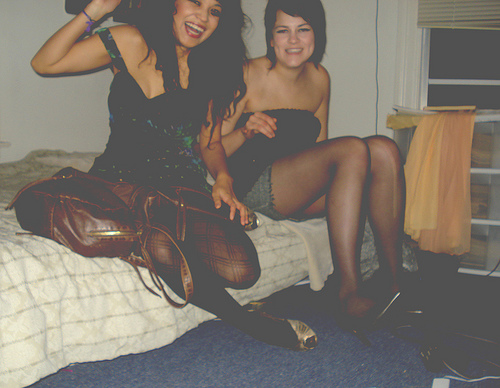

Generated: dinosaur dinosaur dinosaur struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle
Original: Two young ladies are sitting on a small be in skimpy dresses .
--------------------------------------------------


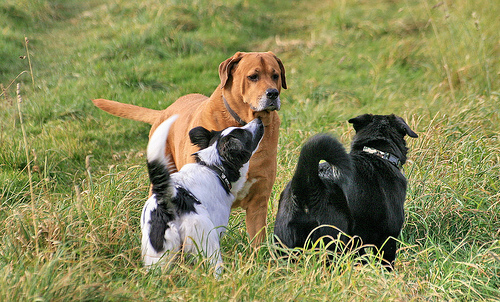

Generated: dinosaur dinosaur struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle
Original: The three dogs are standing in tall grass .
--------------------------------------------------


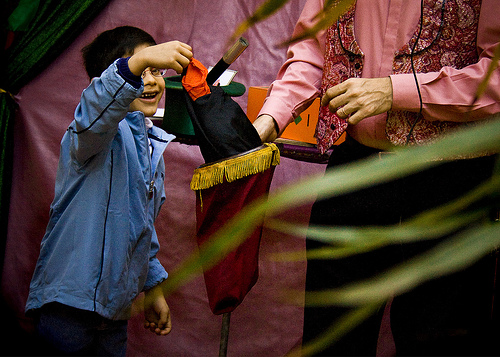

Generated: dinosaur dinosaur struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle struggle
Original: A smiling boy pulling something from a magician 's bag .
--------------------------------------------------


In [21]:
print("--- Pre-training captions ---")
model.eval()
for i, sample in enumerate(test_samples):
    display(sample['image'])
    
    with torch.no_grad():
        # The model's `caption_image` expects a batch, so we add a dimension with unsqueeze(0)
        caption = model.caption_image(test_images[i].unsqueeze(0))
        caption_text = ' '.join(caption)
        print(f"Generated: {caption_text}")
        print(f"Original: {sample['caption']}")
        print("-" * 50)

### 🔹 The Training Loop
The training process involves iterating through the dataset for a number of epochs. In each step:

1.  **Teacher Forcing**: We feed the ground-truth caption (shifted by one position) into the decoder at each time step, regardless of the decoder's own prediction from the previous step. This is a technique called *teacher forcing*, which stabilizes training and helps the model learn the language structure more quickly. We feed `captions[:, :-1]` (from `<SOS>` to the second-to-last word) and expect the model to predict `captions[:, 1:]` (from the first word to `<EOS>`).
2.  **Calculate Loss**: The model's output (logits) is compared against the target sequence to calculate the loss.
3.  **Backpropagation**: The loss is backpropagated through the network to compute gradients.
4.  **Gradient Clipping**: We clip the gradients (`clip_grad_norm_`) to a maximum value. This is a common practice in RNN training to prevent the "exploding gradients" problem.
5.  **Optimizer Step**: The optimizer updates the model's trainable parameters (the decoder and the final layer of the encoder).

In [22]:
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False,
        desc=f"Epoch {epoch+1}/{num_epochs}"
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        # Teacher forcing: feed the ground-truth captions (shifted) to the decoder
        inputs = captions[:, :-1]  # Remove last token (EOS)
        targets = captions[:, 1:]  # Remove first token (SOS)
        
        outputs = model(imgs, inputs)
        
        # Reshape for CrossEntropyLoss and calculate loss
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]),  # Shape: [batch_size * seq_len, vocab_size]
            targets.reshape(-1)                     # Shape: [batch_size * seq_len]
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss) # Save loss for plotting
    print(f'Epoch: {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    if epoch % 10 ==0:    
        model.eval()
        print(f"\n--- Testing after epoch {epoch+1} ---")
        with torch.no_grad():
            random_idx = random.randint(0, len(test_images) - 1)
            test_caption = model.caption_image(test_images[random_idx].unsqueeze(0))
            print(f"Generated: {' '.join(test_caption)}")
            print(f"Original: {test_samples[random_idx]['caption']}")

            random_idx = random.randint(0, len(test_images) - 1)
            test_caption = model.caption_image(test_images[random_idx].unsqueeze(0))
            print(f"Generated: {' '.join(test_caption)}")
            print(f"Original: {test_samples[random_idx]['caption']}")
        print("-" * 50)

Epoch: 1/100, Average Loss: 8.1988

--- Testing after epoch 1 ---
Generated: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
Original: Two young ladies are sitting on a small be in skimpy dresses .
Generated: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
Original: A smiling boy pulling something from a magician 's bag .
--------------------------------------------------


Epoch: 2/100, Average Loss: 5.2345


Epoch: 3/100, Average Loss: 4.9013


Epoch: 4/100, Average Loss: 4.7768


Epoch: 5/100, Average Loss: 4.6512


Epoch: 6/100, Average Loss: 4.5091


Epoch: 7/100, Average Loss: 4.4163


Epoch: 8/100, Average Loss: 4.3065


Epoch: 9/100, Average Loss: 4.1995


Epoch: 10/100, Average Loss: 4.1386


Epoch: 11/100, Average Loss: 4.0425

--- Testing after epoch 11 ---
Generated: a man in a red dog in a red and and white dog in a . <EOS>
Original: The three dogs are standing in tall grass .
Generated: a man in a red dog in a red and and white dog in a beach . <EOS>
Original: Two young ladies are sitting on a small be in skimpy dresses .
--------------------------------------------------


Epoch: 12/100, Average Loss: 3.9650


Epoch: 13/100, Average Loss: 3.8892


Epoch: 14/100, Average Loss: 3.8261


Epoch: 15/100, Average Loss: 3.7794


Epoch: 16/100, Average Loss: 3.7168


Epoch: 17/100, Average Loss: 3.6817


Epoch: 18/100, Average Loss: 3.6303


Epoch: 19/100, Average Loss: 3.5987


Epoch: 20/100, Average Loss: 3.5467


Epoch: 21/100, Average Loss: 3.5284

--- Testing after epoch 21 ---
Generated: a man is standing on a green field . <EOS>
Original: Two young ladies are sitting on a small be in skimpy dresses .
Generated: a man in a blue shirt is is is standing on a field . <EOS>
Original: A smiling boy pulling something from a magician 's bag .
--------------------------------------------------


Epoch: 22/100, Average Loss: 3.4874


Epoch: 23/100, Average Loss: 3.4430


Epoch: 24/100, Average Loss: 3.4237


Epoch: 25/100, Average Loss: 3.3825


Epoch: 26/100, Average Loss: 3.3661


Epoch: 27/100, Average Loss: 3.3232


Epoch: 28/100, Average Loss: 3.2982


Epoch: 29/100, Average Loss: 3.2792


Epoch: 30/100, Average Loss: 3.2601


Epoch: 31/100, Average Loss: 3.2414

--- Testing after epoch 31 ---
Generated: a boy in a red shirt is standing on a field . <EOS>
Original: Two young ladies are sitting on a small be in skimpy dresses .
Generated: a dog is running through the grass . <EOS>
Original: The three dogs are standing in tall grass .
--------------------------------------------------


Epoch: 32/100, Average Loss: 3.2125


Epoch: 33/100, Average Loss: 3.1821


Epoch: 34/100, Average Loss: 3.1556


Epoch: 35/100, Average Loss: 3.1433


Epoch: 36/100, Average Loss: 3.1146


Epoch: 37/100, Average Loss: 3.0998


Epoch: 38/100, Average Loss: 3.0677


Epoch: 39/100, Average Loss: 3.0435


Epoch: 40/100, Average Loss: 3.0224


Epoch: 41/100, Average Loss: 2.9920

--- Testing after epoch 41 ---
Generated: a dog is running through the grass . <EOS>
Original: The three dogs are standing in tall grass .
Generated: a dog is running through the grass . <EOS>
Original: The three dogs are standing in tall grass .
--------------------------------------------------


Epoch: 42/100, Average Loss: 2.9778


Epoch: 43/100, Average Loss: 2.9577


Epoch: 44/100, Average Loss: 2.9274


Epoch: 45/100, Average Loss: 2.9153


Epoch: 46/100, Average Loss: 2.8979


Epoch: 47/100, Average Loss: 2.8755


Epoch: 48/100, Average Loss: 2.8635


Epoch: 49/100, Average Loss: 2.8486


Epoch: 50/100, Average Loss: 2.8255


Epoch: 51/100, Average Loss: 2.8019

--- Testing after epoch 51 ---
Generated: a man in a red shirt is sitting on a wooden bench . <EOS>
Original: A smiling boy pulling something from a magician 's bag .
Generated: a black and white dog is running through the grass . <EOS>
Original: The three dogs are standing in tall grass .
--------------------------------------------------


Epoch: 52/100, Average Loss: 2.7829


Epoch: 53/100, Average Loss: 2.7610


Epoch: 54/100, Average Loss: 2.7439


Epoch: 55/100, Average Loss: 2.7433


Epoch: 56/100, Average Loss: 2.7129


Epoch: 57/100, Average Loss: 2.7052


Epoch: 58/100, Average Loss: 2.7017


Epoch: 59/100, Average Loss: 2.6678


Epoch: 60/100, Average Loss: 2.6567


Epoch: 61/100, Average Loss: 2.6390

--- Testing after epoch 61 ---
Generated: a young boy in a blue shirt is sitting on a wooden bench . <EOS>
Original: A smiling boy pulling something from a magician 's bag .
Generated: a young boy in a blue shirt is sitting on a wooden bench . <EOS>
Original: A smiling boy pulling something from a magician 's bag .
--------------------------------------------------


Epoch: 62/100, Average Loss: 2.6259


Epoch: 63/100, Average Loss: 2.6289


Epoch: 64/100, Average Loss: 2.6020


Epoch: 65/100, Average Loss: 2.5891


Epoch: 66/100, Average Loss: 2.5752


Epoch: 67/100, Average Loss: 2.5617


Epoch: 68/100, Average Loss: 2.5423


Epoch: 69/100, Average Loss: 2.5385


Epoch: 70/100, Average Loss: 2.5172


Epoch: 71/100, Average Loss: 2.5095

--- Testing after epoch 71 ---
Generated: a brown dog is running through the grass . <EOS>
Original: The three dogs are standing in tall grass .
Generated: a man in a red shirt is sitting on a wooden bench . <EOS>
Original: A smiling boy pulling something from a magician 's bag .
--------------------------------------------------


Epoch: 72/100, Average Loss: 2.4897


Epoch: 73/100, Average Loss: 2.4920


Epoch: 74/100, Average Loss: 2.4675


Epoch: 75/100, Average Loss: 2.4469


Epoch: 76/100, Average Loss: 2.4449


Epoch: 77/100, Average Loss: 2.4245


Epoch: 78/100, Average Loss: 2.4209


Epoch: 79/100, Average Loss: 2.3960


Epoch: 80/100, Average Loss: 2.3816


Epoch: 81/100, Average Loss: 2.3784

--- Testing after epoch 81 ---
Generated: a boy in a red shirt is sitting on a wooden bench . <EOS>
Original: A smiling boy pulling something from a magician 's bag .
Generated: a boy in a red shirt is sitting on a wooden bench . <EOS>
Original: A smiling boy pulling something from a magician 's bag .
--------------------------------------------------


Epoch: 82/100, Average Loss: 2.3647


Epoch: 83/100, Average Loss: 2.3624


Epoch: 84/100, Average Loss: 2.3323


Epoch: 85/100, Average Loss: 2.3362


Epoch: 86/100, Average Loss: 2.3291


Epoch: 87/100, Average Loss: 2.3132


Epoch: 88/100, Average Loss: 2.2968


Epoch: 89/100, Average Loss: 2.2675


Epoch: 90/100, Average Loss: 2.2702


Epoch: 91/100, Average Loss: 2.2558

--- Testing after epoch 91 ---
Generated: a girl in a blue shirt and blue shorts is running on a sidewalk . <EOS>
Original: Two young ladies are sitting on a small be in skimpy dresses .
Generated: a girl in a blue shirt and blue shorts is running on a sidewalk . <EOS>
Original: Two young ladies are sitting on a small be in skimpy dresses .
--------------------------------------------------


Epoch: 92/100, Average Loss: 2.2403


Epoch: 93/100, Average Loss: 2.2385


Epoch: 94/100, Average Loss: 2.2210


Epoch: 95/100, Average Loss: 2.2121


Epoch: 96/100, Average Loss: 2.1992


Epoch: 97/100, Average Loss: 2.1901


Epoch: 98/100, Average Loss: 2.1813


Epoch: 99/100, Average Loss: 2.1626


Epoch: 100/100, Average Loss: 2.1533


### 🔹 Plotting the Training Progress
Visualizing the loss helps us understand how well the model is learning. A decreasing loss indicates that the model is successfully minimizing its prediction error over time.

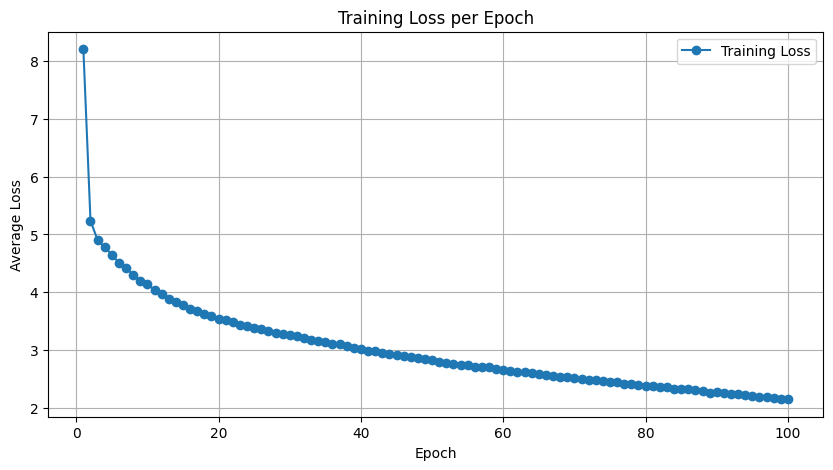

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, 'o-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

## 6️⃣ Saving and Loading the Model

To avoid retraining the model every time we want to use it, we can save its state. It's good practice to save three things:
1.  **Model State Dictionary**: The learned weights and biases of the model.
2.  **Vocabulary Mappings**: The `word_to_index` and `index_to_word` dictionaries are essential for converting between words and indices during inference.
3.  **Model Configuration**: The hyperparameters used to build the model (`embed_size`, `hidden_size`, etc.), so we can perfectly reconstruct the architecture before loading the weights.

In [24]:
def save_model(model, word_to_index, index_to_word, model_config, save_dir="flickr8k_rnn_image_captioning_dataset"):
    """
    Save the trained model, vocabulary, and configuration to a specified directory.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model state dict
    model_path = os.path.join(save_dir, 'flickr8k_image_captioner.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model state dict saved to '{model_path}'")
    
    # Save vocabulary mappings
    vocab_data = {
        'word_to_index': word_to_index,
        'index_to_word': index_to_word,
        'vocab_size': len(word_to_index)
    }
    vocab_path = os.path.join(save_dir, 'vocab_mappings.pkl')
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab_data, f)
    print(f"Vocabulary mappings saved to '{vocab_path}'")
    
    # Save model configuration
    config_path = os.path.join(save_dir, 'model_config.pkl')
    with open(config_path, 'wb') as f:
        pickle.dump(model_config, f)
    print(f"Model configuration saved to '{config_path}'")
    
    print(f"\nAll files saved successfully in '{save_dir}' directory!")

In [25]:
# Define the model configuration to be saved
model_config = {
    'embed_size': embed_size,
    'hidden_size': hidden_size,
    'vocab_size': vocab_size,
    'num_decoder_layers': num_decoder_layers
}

# Save the current trained model
save_model(model, word_to_index, index_to_word, model_config)

Model state dict saved to 'flickr8k_rnn_image_captioning_dataset/flickr8k_image_captioner.pth'
Vocabulary mappings saved to 'flickr8k_rnn_image_captioning_dataset/vocab_mappings.pkl'
Model configuration saved to 'flickr8k_rnn_image_captioning_dataset/model_config.pkl'

All files saved successfully in 'flickr8k_rnn_image_captioning_dataset' directory!


In [26]:
def load_model(save_dir="flickr8k_rnn_image_captioning_dataset", device='cpu'):
    """
    Load the trained model, vocabulary, and configuration from a specified directory.
    """
    # Load vocabulary mappings
    vocab_path = os.path.join(save_dir, 'vocab_mappings.pkl')
    with open(vocab_path, 'rb') as f:
        vocab_data = pickle.load(f)
    print(f"Vocabulary mappings loaded from '{vocab_path}'")
    
    # Load model configuration
    config_path = os.path.join(save_dir, 'model_config.pkl')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    print(f"Model configuration loaded from '{config_path}'")
    
    # Recreate model architecture using the loaded config
    model = ImageCaptioner(
        config['embed_size'], 
        config['hidden_size'], 
        config['vocab_size'], 
        config['num_decoder_layers']
    )
    
    # Load model weights
    model_path = os.path.join(save_dir, 'flickr8k_image_captioner.pth')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval() # Set model to evaluation mode
    print(f"Model weights loaded from '{model_path}'")
    
    print(f"\nModel loaded successfully from '{save_dir}' directory!")
    return model, vocab_data['word_to_index'], vocab_data['index_to_word']

In [27]:
# Example of loading the model
# We also reload the vocabulary to ensure consistency, especially if running this section independently
loaded_model, word_to_index_loaded, index_to_word_loaded = load_model(device=device)

Vocabulary mappings loaded from 'flickr8k_rnn_image_captioning_dataset/vocab_mappings.pkl'
Model configuration loaded from 'flickr8k_rnn_image_captioning_dataset/model_config.pkl'
Model weights loaded from 'flickr8k_rnn_image_captioning_dataset/flickr8k_image_captioner.pth'

Model loaded successfully from 'flickr8k_rnn_image_captioning_dataset' directory!


## 7️⃣ Generating Captions (Inference)
Finally, let's see our trained model in action! We will use the same test images from our pre-training check and compare the new, hopefully much-improved, captions.

The model is set to evaluation mode (`model.eval()`) to disable layers like Dropout that are only used during training.


--- Post-training captions ---


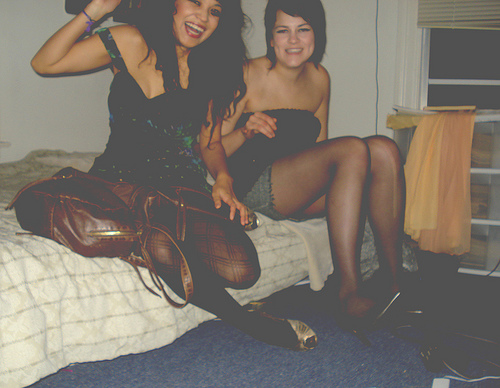

Image 1:
  Generated: a girl in a blue shirt and a black girl is playing on a wooden bench . <EOS>
  Original:  Two young ladies are sitting on a small be in skimpy dresses .
--------------------------------------------------


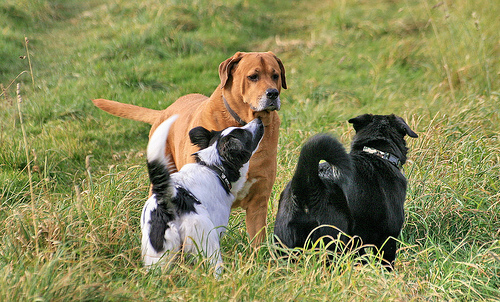

Image 2:
  Generated: a brown dog and a black dog are in a field . <EOS>
  Original:  The three dogs are standing in tall grass .
--------------------------------------------------


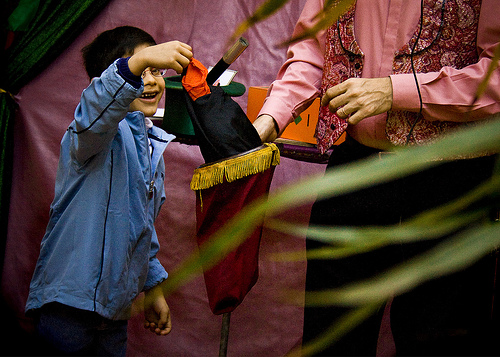

Image 3:
  Generated: a young boy in a red shirt and a black dog is sitting on a wooden totter . <EOS>
  Original:  A smiling boy pulling something from a magician 's bag .
--------------------------------------------------


In [28]:
model.eval() # Ensure model is in evaluation mode

print("\n--- Post-training captions ---")

for i, sample in enumerate(test_samples):
    display(sample['image'])
    
    with torch.no_grad():
        caption = model.caption_image(test_images[i].unsqueeze(0))
        caption_text = ' '.join(caption)
        print(f"Image {i+1}:")
        print(f"  Generated: {caption_text}")
        print(f"  Original:  {sample['caption']}")
        print("-" * 50)

## 8️⃣ Conclusion & Next Steps

We have successfully built, trained, and evaluated an image captioning model using a CNN encoder and an RNN decoder. While the results after a short training run are promising, they can be significantly improved.

### **📝 Exercises for Further Exploration**
1.  **More Training**: The most impactful change would be to train for more `epochs` on a larger portion of the dataset (or the full dataset). Deep learning models are data-hungry!
2.  **Hyperparameter Tuning**: Experiment with different values for `embed_size`, `hidden_size`, `num_decoder_layers`, and `learning_rate`.
3.  **Different RNNs**: Replace the `nn.LSTM` with a `nn.GRU` in the decoder. Compare the results and training time.
4.  **Attention Mechanism**: The biggest architectural improvement for this task is to add an **attention mechanism**. Attention allows the decoder to dynamically focus on different parts of the image as it generates each word, often leading to more accurate and contextually relevant captions. This is a key component in modern sequence-to-sequence models.
5.  **Beam Search Decoding**: The current `caption_image` method uses greedy decoding (picking the single best word at each step). Implement **beam search**, which keeps track of the `k` most probable sequences at each step, often resulting in higher-quality final captions.

### Contributed by: Ali Habibullah(Changed from Telha Bilal original notebook 🫡)